# Facilities KPI Scorecard
This notebook serves as a repository of public-facing KPIs for the Department of General Services' Facilities Division. The purpose of this notebook is to make available, in a single public place, the entire pipeline for calculating the division's three KPIs that are based in Archibus. Those KPIs are:

1. % of Corrective Maintenance Work Requests Completed On Time
2. % of Preventive Maintenance Work Requests Completed On Time
3. Preventive Maintenance to Corrective Maintenance Ratio

Part of the intention of this notebook is to build _transparency_ and _reproducibility_ by capturing the entire end-to-end process used to calculate these metrics in one place.

The actuals for previous year for KPIs 1 and 2 shown here are slightly higher than those reported in the Clear Impact budget book. That is because a coding error caused us to undercount the data. That error has now been fixed and the numbers shown here are more accurate. 

__Questions__: This notebook was last modified by James Trimarco, DGS Research Analyst, on May 11 2021. Questions and concerns about this work can be directed to james.trimarco@baltimorecity.gov.

__Note__: After the implementation of our Archibus dashboards and their incorporation into management workflows, DGS became aware of the need to further improve the third metric (Preventive Maintenance to Corrective Maintenance Ratio). Because this metric is still under construction, it is not shown here. 

## Setup

### Import packages
This step imports a group of common analysis packages, as well as a few custom functions. 

In [1]:
# workhorse modules
import pandas as pd
from datetime import timedelta, datetime
import re
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

# local utility functions
from kpicentral.general_utils import (
    cast_dtypes,
    tidy_up_df, 
    clean_up_colnames,
    set_pd_params,
    compute_pm_cm,
    compute_kpi_table,
)
from kpicentral.archibus import Archibus
from kpicentral.vis_utils import set_plot_params, pointplot_with_barplot
from kpicentral.anonymization import split_names, replace_names

### Set Pandas options
This makes the Pandas library print all the rows and columns to the output, instead of truncating output. 

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
set_pd_params()
set_plot_params(width=12, height=7)
pd.options.mode.chained_assignment = None  # default='warn'



### Import the work request data from Archibus database
The command below pulls every row from Archibus's `dash_benchmarks` table, which enhances the raw operational data by adding several important columns including:

- __primary_type__: Consolidates the `problem_type` down from more than 100 raw types into just 30 consolidated and benchmarked problem types.
- __days_to_completion__: Number of days between the date a job was requested and the date it was marked completed.
- __benchmark__: Number of days that can pass between request and completion before a job is marked late. 

The resulting data contains the entire work request history. No filtering by date has been applied yet. 

Readers interested in the steps used to create `dash_benchmarks` from the raw operational data can find [the SQL query used to do this here](https://raw.githubusercontent.com/department-of-general-services/fmd_archibus_dashboard/master/create_views_facilities_dashboard.sql).


In [36]:
sql_file_path = Path.cwd().parent / 'sql' / 'get_kpis_from_benchmarks.sql'
sql_file= open(sql_file_path, 'r')

In [37]:
archibus = Archibus()
results = archibus.execute_stmt(query_str=sql_file.read())
df_raw = results.dataframe
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112105 entries, 0 to 112104
Data columns (total 34 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   wr_id                       112105 non-null  int64         
 1   status                      112105 non-null  object        
 2   description                 103492 non-null  object        
 3   supervisor                  88054 non-null   object        
 4   work_team_id                53552 non-null   object        
 5   date_requested              112105 non-null  datetime64[ns]
 6   date_completed              101192 non-null  datetime64[ns]
 7   date_closed                 102207 non-null  datetime64[ns]
 8   problem_type                112105 non-null  object        
 9   pm_group                    9627 non-null    object        
 10  is_vendor_work              112105 non-null  object        
 11  primary_type                112105 non-

## Data cleaning
For the purposes of this project, DGS is keeping the data-cleaning stage simple. We're not attempting to remove duplicates or outliers, both of which involve relatively complex operations. 

In [38]:
df_untyped = tidy_up_df(df_raw)
df_untyped = clean_up_colnames(df_untyped)

print(f"The tidied work orders dataframe has {len(df_untyped):,} rows.")
print(f"By tidying the data, we have removed {len(df_raw) - len(df_untyped):,} rows.")

The tidied work orders dataframe has 112,105 rows.
By tidying the data, we have removed 0 rows.


In [39]:
df_typed = cast_dtypes(df_untyped)

Here's a sample of a few rows, showing some of the key columns.

In [40]:
df_typed.sample(3, random_state=445)[
    [
        "wr_id",
        "status",
        "primary_type",
        "status",
        "date_requested",
        "date_completed",
        "days_to_completion",
        "date_closed",
        "is_on_time",
    ]
]

,wr_id,status,primary_type,status,date_requested,date_completed,days_to_completion,date_closed,is_on_time
73974,98591,Clo,LOCK,Clo,2018-01-09,2018-01-11,2.0,2018-01-11 06:36:37.953,True
89487,79098,Clo,PREVENTIVE_GENERAL,Clo,2016-11-25,2016-12-29,34.0,2017-01-06 15:12:39.230,False
73603,147960,Com,PREVENTIVE_HVAC,Com,2021-08-05,2021-09-17,43.0,NaT,False


### Drop canceled and rejected work orders
The data comes to us with many canceled work orders. Those shouldn't count against our KPIs as not having been completed on time. So we drop them here. 

In [41]:
# drop rows that were canceled or rejected
cond_valid = ~df_typed["status"].isin(["Can", "Rej"])

df_valid = df_typed[cond_valid]

print(
    f"By dropping canceled and rejected work orders, we have removed {len(df_typed) - len(df_valid):,} rows."
)

By dropping canceled and rejected work orders, we have removed 4,500 rows.


## Data preparation

After assigning the fiscal year, we can drop work requests from FY16 and older. This allows us to focus on recent history. 

In [56]:
cond_fy = df_valid["fy_complete"].isin(range(2016, 2023))
df_fy = df_valid[cond_fy]

print(
    f"Filtering to remove data requested before FY17 leaves us with {len(df_fy):,} rows.",
    f"\nWe dropped {round((100 * (len(df_valid) - len(df_fy)))/len(df_valid), 2):}% of the data at this stage.",
)

Filtering to remove data requested before FY17 leaves us with 77,094 rows. 
We dropped 28.35% of the data at this stage.


### Save to disk if needed

In [47]:
# df_sample = df_fy.sample(n=500)
# path_to_save = Path.cwd().parent / 'data' / 'FY17_to_FY21_sample.csv'

# df_sample.to_csv(path_to_save)

## KPI 1: % PMs Completed On Time 
The goal here is to filter the data to preventive maintenance jobs only, and then show how many are completed on or before the benchmark (21 days).

### Filter to  preventive maintenance work requests only
For this metric, we want to select every single PM that Facilities Management does. We can do this by selecting 5 values for the original, non-consolidated problem type. 

In [11]:
df_pm = df_fy.copy()

# filter data to PM types only
cond_pm = df_pm["is_any_pm"] == True

# apply filter conditions
df_pm = df_pm[cond_pm]

print(f"The filtered PMs dataframe has {len(df_pm):,} rows.")

The filtered PMs dataframe has 7,503 rows.


#### Inspect the relevant rows
A look at the data shows that PMs that took longer than 21 days to complete now contain a value of False in the colum `is_on_time`. PMs that were completed in 21 days or fewer contain a True. 

In [12]:
df_pm[
    [
        "problem_type",
        "pm_group",
        "date_requested",
        "date_completed",
        "days_to_completion",
        "completion_benchmark",
        "is_on_time",
    ]
].sample(3, random_state=447)

,problem_type,pm_group,date_requested,date_completed,days_to_completion,completion_benchmark,is_on_time
26624,BUILDING INTERIOR INSPECTION,None,2018-07-24,2018-07-24,0.0,21,True
79930,PREVENTIVE MAINT,HEATING LEVELS,2020-12-07,2021-05-11,155.0,21,False
79052,PREVENTIVE MAINT,HEATING LEVELS,2018-10-22,2019-07-05,256.0,21,False


#### Group by fiscal year and get % on time
Now that we've stored all this information, we can group by the fiscal year to get each year's KPI, together with a count of how many PMs were closed in that fiscal year.

In [13]:
pm_compliance = compute_kpi_table(
    df_pm, "percent_PMs_on_time", "total_PMs", grouping_var="fy_close"
)
pm_compliance

,percent_PMs_on_time,total_PMs
fy_close,,
2017,52.05,1195
2018,80.50,1195
2019,92.42,765
2020,49.53,1902
2021,30.29,1951
2022,58.24,170


### Visualization: % Preventive Work Requests on Time by Fiscal Year Closed
Fiscal years 2020 and 2021 were characterized by the closing out of many backlog work requests, which lowered the percentage of work requests that are on time. 

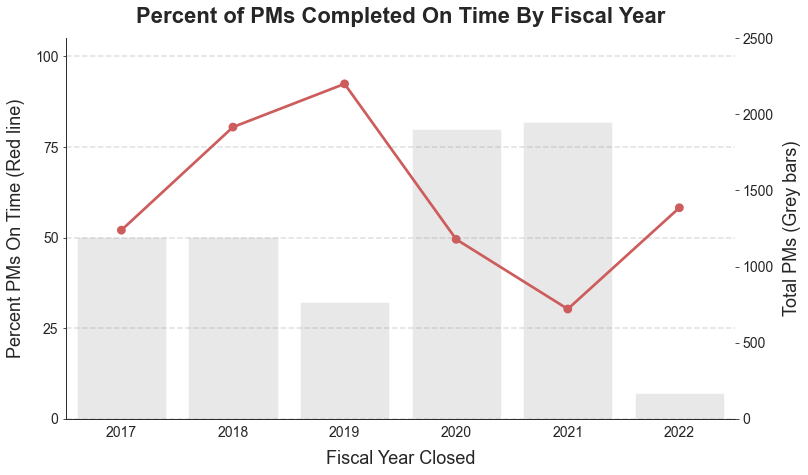

In [14]:
pointplot_with_barplot(
    pm_compliance,
    x=pm_compliance.index,
    point_y="percent_PMs_on_time",
    bar_y="total_PMs",
    yaxis_freq_bar=500,
    yaxis_freq_point=25,
    ymax_bar=2_500,
    xlabel="Fiscal Year Closed",
    ylabel_point="Percent PMs On Time (Red line)",
    ylabel_bar="Total PMs (Grey bars)",
    title="Percent of PMs Completed On Time By Fiscal Year",
)

## KPI 2: Percent of Corrective Work Requests Completed On-Time
Here are the key facts needed to understand the agency's new method for computing this KPI:

- Only corrective problem types are considered, so all preventive work requests are dropped.
- The work orders are first assigned a "primary" problem type, which reduces the number of problem types from about 110 to 30
- Each of these primary problem types has an on-time benchmark 
- The work order is determined to be on-time based on comparing its time to completion to its benchmark

### Filter to get CMs only

In [15]:
df_pm = df_fy.copy()

# filter data to PM types only
cond_pm = df_pm["is_any_pm"] == True

# apply filter conditions
df_pm = df_pm[cond_pm]

print(f"The filtered PMs dataframe has {len(df_pm):,} rows.")

The filtered PMs dataframe has 7,503 rows.


In [16]:
df_cm = df_fy.copy()

# filter data to PM types only
cond_cm = df_cm["is_any_pm"] == False

# apply filter conditions
df_cm = df_cm[cond_cm]

print(f"The filtered CMs dataframe has {len(df_cm):,} rows.")

The filtered CMs dataframe has 53,265 rows.


In [17]:
df_cm.sample(6, random_state=444)[
    ["problem_type", "primary_type", "completion_benchmark", "days_to_completion"]
]

,problem_type,primary_type,completion_benchmark,days_to_completion
55617,PLUMB/LEAK,PLUMBING,14,0.0
3957,OTHER,OTHER-INTERNAL,7,0.0
918,HVAC,HVAC,30,77.0
61450,CEILTILE,CEILTILE,14,0.0
105524,PLUMBING-WATER SUPPLY,PLUMBING,14,35.0
4024,ELEC/LIGHT,ELECTRICAL,14,2.0


### Group by fiscal year to get % on time per fiscal year

In [18]:
cm_compliance = compute_kpi_table(
    df_cm, "percent_CMs_on_time", "total_CMs", grouping_var="fy_close"
)
cm_compliance

,percent_CMs_on_time,total_CMs
fy_close,,
2017,73.38,12410
2018,70.97,9922
2019,66.62,5644
2020,53.22,8839
2021,37.14,11181
2022,54.59,1885


### Visualization: % Corrective Work Requests on Time by Fiscal Year Closed
Efforts to close out the backlog bring the FY21 number down a bit. Facilities Maintenance expects FY22 figures to improve as 

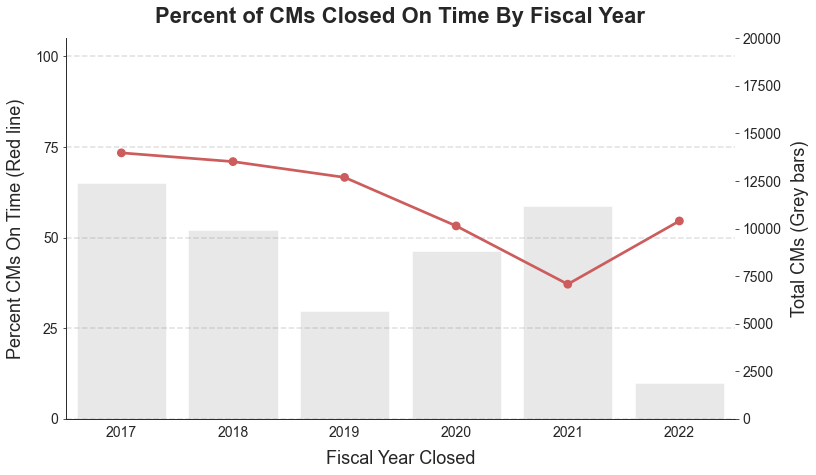

In [19]:
pointplot_with_barplot(
    cm_compliance,
    x=cm_compliance.index,
    point_y="percent_CMs_on_time",
    bar_y="total_CMs",
    yaxis_freq_bar=2500,
    yaxis_freq_point=25,
    ymax_bar=20_000,
    xlabel="Fiscal Year Closed",
    ylabel_point="Percent CMs On Time (Red line)",
    ylabel_bar="Total CMs (Grey bars)",
    title="Percent of CMs Closed On Time By Fiscal Year",
)

## KPI 3: Percent of All WRs Completed On Time

### No filter needed

In [20]:
df_all = df_fy.copy()

print(f"The filtered CMs dataframe has {len(df_all):,} rows.")

The filtered CMs dataframe has 60,768 rows.


In [21]:
df_all.sample(6, random_state=444)[
    ["problem_type", "primary_type", "completion_benchmark", "days_to_completion"]
]

,problem_type,primary_type,completion_benchmark,days_to_completion
7933,PLUMB/UNCLOG,PLUMBING,14,33.0
28867,SERV/CUSTODIAL,SERVICE,14,0.0
87151,HVAC,HVAC,30,21.0
91254,PLUMB/OTHER,PLUMBING,14,9.0
57771,OVERHDDOOR,OVERHDDOOR,45,50.0
23234,BATHROOM_FIXT,BATHROOM,14,0.0


### Group by Fiscal Year to get KPI

In [22]:
all_compliance = compute_kpi_table(
    df_all, "percent_WRs_on_time", "total_work_requests", grouping_var="fy_close"
)
all_compliance

,percent_WRs_on_time,total_work_requests
fy_close,,
2017,71.50,13605
2018,72.00,11117
2019,69.70,6409
2020,52.56,10741
2021,36.13,13132
2022,54.89,2055


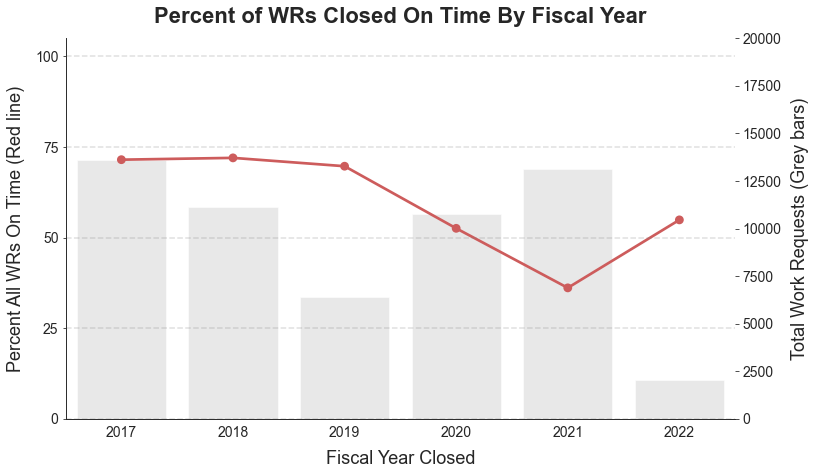

In [23]:
pointplot_with_barplot(
    all_compliance,
    x=all_compliance.index,
    point_y="percent_WRs_on_time",
    bar_y="total_work_requests",
    yaxis_freq_bar=2500,
    yaxis_freq_point=25,
    ymax_bar=20_000,
    xlabel="Fiscal Year Closed",
    ylabel_point="Percent All WRs On Time (Red line)",
    ylabel_bar="Total Work Requests (Grey bars)",
    title="Percent of WRs Closed On Time By Fiscal Year",
)

## KPI 4: PM:CM Ratio

This KPI remains under contstruction as DGS works to choose categories of related categories of preventive and corrective maintenance that extend beyond just HVAC. Therefore, we've commented out the code for this KPI. 

In [24]:
CM_list = [
    "BOILER",
    "CHILLERS",
    "COOLING TOWERS",
    "HVAC",
    "HVAC INFRASTRUCTURE",
    "HVAC|REPAIR",
]

PM_list = [
    "HVAC|PM",
    "PREVENTIVE MAINT",
]

### Filter to HVAC rows only

In [25]:
df_main = df_fy.copy()

# filter data to PM types only
cond_cm = df_main["problem_type"].isin(CM_list)
cond_pm = df_main["problem_type"].isin(PM_list)

df_HVAC = df_main[cond_cm | cond_pm]
df_HVAC["is_pm"] = df_HVAC["problem_type"].isin(PM_list)

print(
    f"Filtering to HVAC request only takes us from {len(df_fy):,} rows to {len(df_HVAC):,} rows."
)

Filtering to HVAC request only takes us from 60,768 rows to 17,370 rows.


### Compute all PM/CM stats by fiscal year
First we deploy a custom function that counts the PMs and CMs in each fiscal year and then calculates the PM:CM ratio.

In [32]:
pm_cm_results = compute_pm_cm(df_HVAC, grouping_var='fy_complete')

2017
2018
2019
2020
2021
2022


In [33]:
pm_cm_results

,pm_cm_ratio,percent_pm,count_cm,count_pm,count_hvac,fy_complete
0,0.61:1,60.53,2095,1268,3363,2017
1,0.65:1,64.89,2615,1697,4312,2018
2,0.58:1,57.73,1805,1042,2847,2019
3,0.66:1,66.35,2089,1386,3475,2020
4,0.71:1,70.60,1527,1078,2605,2021
5,0.19:1,19.25,644,124,768,2022


### Plot PM:CM ratio by fiscal year

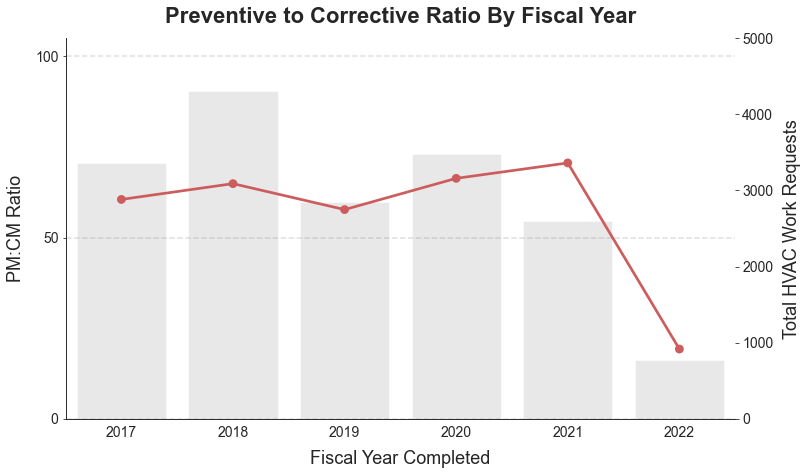

In [34]:
pointplot_with_barplot(
    pm_cm_results,
    x="fy_complete",
    point_y="percent_pm",
    bar_y="count_hvac",
    ymax_bar=5_000,
    yaxis_freq_bar=1000,
    xlabel="Fiscal Year Completed",
    ylabel_point="PM:CM Ratio",
    ylabel_bar="Total HVAC Work Requests",
    title="Preventive to Corrective Ratio By Fiscal Year",
    #yticklabels=["0","0.25:1", "0.5:1", "0.75:1", "1:1"],
)

### Plot the number of PMs and CMs by fiscal year
We can get a little more insight into what's going on with the ratio by checking out the raw counts of preventive and corrective maintenance work requests by fiscal year. 

In [ ]:
# count_plot_data = pd.melt(
#     pm_cm_results, id_vars=["fiscal_year"], value_vars=["count_cm", "count_pm"]
# )

# ax = sns.lineplot(data=count_plot_data, y="value", x="fiscal_year", hue="variable")
# new_labels = ["Corrective", "Preventive"]
# plt.legend(title="Number of Work Orders", loc="upper left", labels=new_labels)

# ax.set(
#     title="Volume of HVAC PMs And CMs By Fiscal Year",
#     xlabel="Fiscal Year",
#     ylim=(0, 3000),
# )
# sns.despine()